## **Import Necessary Libraries**

In [ ]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import *
from google.colab import files
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler

##**Upload KAGGLE.JSON FILE**

In [ ]:
files.upload()

##**Extract dataset**

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install and authenticate Kaggle
!pip install kaggle
!kaggle datasets download -d alsaniipe/chest-x-ray-image

# Extract dataset
!unzip -q chest-x-ray-image.zip -d chest_xray_dataset

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image
License(s): apache-2.0


# **Instances check**

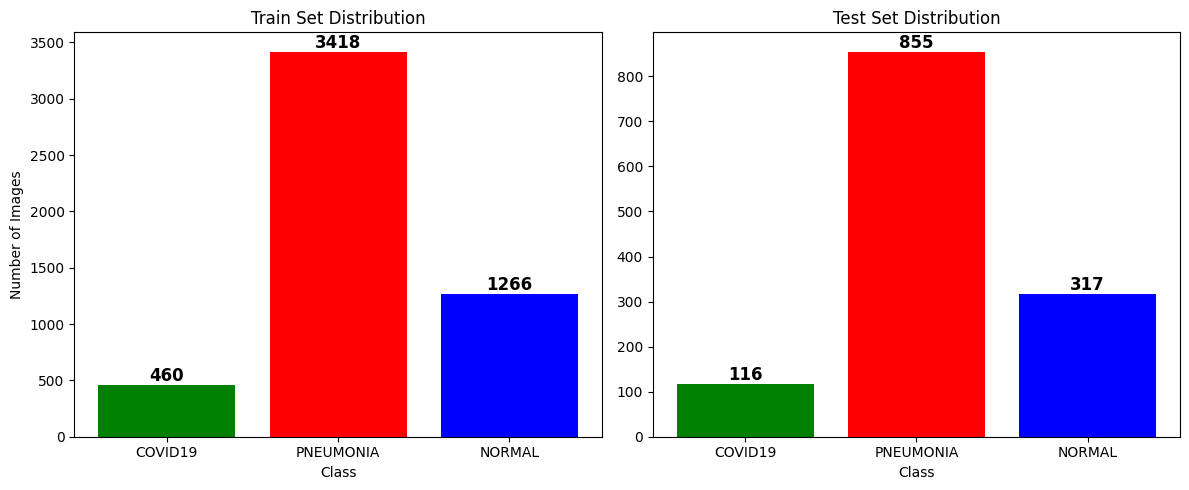

In [ ]:
# Define dataset paths (Update with actual paths)
train_path = "chest_xray_dataset/Data/train"
test_path = "chest_xray_dataset/Data/test"

# List all class folders
classes = ["COVID19", "PNEUMONIA", "NORMAL"]

# Function to count images in each class
def count_images(dataset_path):
    return {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Get class distributions
train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set
bars_train = axes[0].bar(train_counts.keys(), train_counts.values(), color=['green', 'red', 'blue'])
axes[0].set_title("Train Set Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")

# Adding numbers on top of bars
for bar in bars_train:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Testing set
bars_test = axes[1].bar(test_counts.keys(), test_counts.values(), color=['green', 'red', 'blue'])
axes[1].set_title("Test Set Distribution")
axes[1].set_xlabel("Class")

# Adding numbers on top of bars
for bar in bars_test:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## **Define PDCOVIDNet Model**

The model follows a two-branch parallel dilated convolutional structure, which extracts features using dilated convolutions at different scales.

In [ ]:
class DilatedConvBlock(nn.Module):
    #Define a custom CNN block
    #__init__ method is used to initialize the module’s parameters
    def __init__(self, in_channels, out_channels, dilation):
        super(DilatedConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding = dilation, dilation=dilation)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = dilation, dilation=dilation)
        self.relu2 = nn.ReLU(inplace=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #Forward pass (Conv → ReLU → Conv → ReLU → MaxPool)
    #used to perform the computation that the module represents
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        return x

#Main model class
class PDCOVIDNet(nn.Module):
    def __init__(self, num_classes=3):
        super(PDCOVIDNet, self).__init__()

        # Branch 1
        self.branch1 = nn.Sequential(
            DilatedConvBlock(1, 64, dilation=1),
            DilatedConvBlock(64, 128, dilation=1),
            DilatedConvBlock(128, 256, dilation=1),
            DilatedConvBlock(256, 512, dilation=1),
            DilatedConvBlock(512, 512, dilation=1),
        )

        # Branch 2
        self.branch2 = nn.Sequential(
            DilatedConvBlock(1, 64, dilation=2),
            DilatedConvBlock(64, 128, dilation=2),
            DilatedConvBlock(128, 256, dilation=2),
            DilatedConvBlock(256, 512, dilation=2),
            DilatedConvBlock(512, 512, dilation=2),
        )

        # After element-wise addition
        self.conv_fuse = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024) #nn.Linear(num_inputs, hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(1024, num_classes)

    #mainly starts from here
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)

        # Element-wise addition
        out = out1 + out2 #generates the same shape after addition

        # Additional Conv layer after fusion
        out = self.conv_fuse(out)

        # Flatten the previous output that we got after fusion
        out = out.view(out.size(0), -1)

        # Fully connected layers (separated operations)
        out = self.fc1(out)          # Linear transformation
        out = F.relu(out)            # ReLU activation
        out = self.dropout1(out)     # Dropout

        out = self.fc2(out)          # Linear transformation
        out = F.relu(out)            # ReLU activation
        out = self.dropout2(out)     # Dropout

        out = self.fc3(out)          # Final linear transformation

        return out  # CrossEntropyLoss applies LogSoftmax internally

# **Handle Class Imbalance with Weighted Loss**

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15),
        scale=(0.9, 1.1),
        shear=10,
        interpolation=transforms.InterpolationMode.NEAREST
    ),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

## **Create Dataset and Dataloader**
The **dataset** loads and labels all images, while the **dataloader** feeds them to model in batches during training or testing

In [ ]:
# Load training and test images
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_transform)

# get class labels and their counts
label_to_class = train_dataset.class_to_idx  # {'COVID19': 0, 'PNEUMONIA': 1, 'NORMAL': 2}
class_sample_counts = [train_counts[c] for c in label_to_class] #calculating class sample counts

#handle imbalance with weighted sampling (inverse frequency: rarer classes get higher weight)
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

#each sample/image gets a weight depending on its class
sample_weights = [weights[label] for _, label in train_dataset]

#helps oversample minority classes to make more balanced
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure correct class label ordering using label_to_class
label_to_class = train_dataset.class_to_idx  # {'COVID19': 0, 'PNEUMONIA': 1, 'NORMAL': 2}
class_counts_list = [train_counts[c] for c in label_to_class]  # Get counts in index order

# Compute inverse frequency weights and normalize
inv_freq_weights = [1.0 / count for count in class_counts_list]

# Normalize the weights so they sum to 1
norm_weights = [w / sum(inv_freq_weights) for w in inv_freq_weights]

# Define the loss function with computed class weights
class_weights = torch.FloatTensor(norm_weights).to(device)

#define loss function
#Cross-entropy loss measures how well the predicted probability distribution matches the true labels by penalizing incorrect confident predictions
#applies Softmax and then calculates the log of the probabilities before computing the loss
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.0)

# **Train the Model**

In [ ]:
# Model setup
model = PDCOVIDNet(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)  # Learning rate scheduler

# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
no_improve = 0  # Counter for epochs without improvement

# Training loop with time tracking
for epoch in range(20):
    start_time = time.time()  # Start timing

    model.train()
    train_loss = 0.0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    avg_train_loss = train_loss / total_samples

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Estimate remaining time
    elapsed_time = end_time - start_time
    estimated_remaining = epoch_duration * (20 - (epoch + 1))

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")
    print(f"Estimated Time Left: {estimated_remaining/60:.2f} minutes\n")

Epoch 1: Train Loss = 0.8702
Estimated Time Left: 93.66 minutes

Epoch 2: Train Loss = 0.8303
Estimated Time Left: 89.73 minutes

Epoch 3: Train Loss = 0.5865
Estimated Time Left: 84.57 minutes

Epoch 4: Train Loss = 0.4319
Estimated Time Left: 80.49 minutes

Epoch 5: Train Loss = 0.3567
Estimated Time Left: 74.15 minutes

Epoch 6: Train Loss = 0.3350
Estimated Time Left: 69.36 minutes

Epoch 7: Train Loss = 0.2763
Estimated Time Left: 64.29 minutes

Epoch 8: Train Loss = 0.2454
Estimated Time Left: 60.12 minutes

Epoch 9: Train Loss = 0.2340
Estimated Time Left: 55.08 minutes

Epoch 10: Train Loss = 0.2050
Estimated Time Left: 49.24 minutes

Epoch 11: Train Loss = 0.1753
Estimated Time Left: 45.89 minutes

Epoch 12: Train Loss = 0.1756
Estimated Time Left: 40.08 minutes

Epoch 13: Train Loss = 0.1717
Estimated Time Left: 35.30 minutes

Epoch 14: Train Loss = 0.1712
Estimated Time Left: 29.91 minutes

Epoch 15: Train Loss = 0.1584
Estimated Time Left: 25.10 minutes

Epoch 16: Train Los

# **Evaluate with Macro-Averaged Metrics**

In [ ]:
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and print metrics
print('\n' + '='*50)
print('Final Evaluation Metrics on Test Set')
print('='*50)
print('Recall Score:', recall_score(y_true, y_pred, average='macro'))
print('Precision Score:', precision_score(y_true, y_pred, average='macro'))
print('Macro Avg. F1 Score:', f1_score(y_true, y_pred, average='macro'))
print('Accuracy:', accuracy_score(y_true, y_pred))

print('\nClassification Report:')
print(classification_report(
    y_true, y_pred,
    target_names=['COVID19', 'PNEUMONIA', 'NORMAL'],  # Replace with actual class names if different
    digits=4))


Final Evaluation Metrics on Test Set
Recall Score: 0.9434654704857434
Precision Score: 0.8924142851500231
Macro Avg. F1 Score: 0.9151871529516967
Accuracy: 0.9200310559006211

Classification Report:
              precision    recall  f1-score   support

     COVID19     0.8915    0.9914    0.9388       116
   PNEUMONIA     0.8110    0.9338    0.8680       317
      NORMAL     0.9748    0.9053    0.9388       855

    accuracy                         0.9200      1288
   macro avg     0.8924    0.9435    0.9152      1288
weighted avg     0.9270    0.9200    0.9213      1288

